<a href="https://colab.research.google.com/github/E-xxi/kaggle_house-price/blob/data_observe/houseprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **House Prices - Advanced Regression Techniques**
sale prices를 예측하는 것이 주제이다.




우선 데이터의 형태를 관찰해보도록 한다. 

# 파일 다운로드 및 실행

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

%cd /content/gdrive/My Drive/Kaggle
%pwd


Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle


'/content/gdrive/My Drive/Kaggle'

In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques
!ls

%mkdir input/house-price

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 20.8MB/s]
house-prices-advanced-regression-techniques.zip  kaggle.json
input						 lecture07_Project02_2020113677
mv: cannot stat 'house-prices-advanced-regression-techniques': No such file or directory


In [ ]:
%mv house-prices-advanced-regression-techniques.zip input/house-price
%cd input/house-price/

!unzip \*.zip  && rm *.zip

/content/gdrive/MyDrive/Kaggle/input/house-price
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# House Price 데이터 관찰하기

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/content/gdrive/My Drive/Kaggle/input/house-price'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

%pwd

/content/gdrive/My Drive/Kaggle/input/house-price/test.csv
/content/gdrive/My Drive/Kaggle/input/house-price/train.csv
/content/gdrive/My Drive/Kaggle/input/house-price/data_description.txt
/content/gdrive/My Drive/Kaggle/input/house-price/sample_submission.csv


'/content/gdrive/My Drive/Kaggle/input/house-price'

In [6]:
%cd input/house-price/

data = pd.read_csv('train.csv')
#data.info()

[Errno 2] No such file or directory: 'input/house-price/'
/content/gdrive/MyDrive/Kaggle/input/house-price


전체 칼럼을 확인해보면서 특정 유형이 90%이상의 비율을 차지하는 칼럼이 있는지 확인한다.

이것을 확인하는 이유는 반드시 필수적으로 필요한 부분이 무엇인지 그리고 굳이 고려할 필요가 없는 칼럼이 무엇이 있는지를 확인하기 위함이다.

- Dtype이 object 인 경우만 우선 고려하겠다.

값 전체에 대해 90프로를 차지하는 것을 확인한다.

In [7]:
#DType이 object인 경우

overallMaj = pd.DataFrame()
for c in list(data.columns):
  if data[c].dtype != 'object':
    continue

  #특정요소가 라인의 90프로 이상을 차지한다면 출력
  for k in data[c].value_counts().values:
    if k >= data[c].count() * 0.9:
      new = {'title': c, 'val' : data[c].value_counts().keys()[0], 'cnt': k}
      overallMaj = overallMaj.append(new, ignore_index = True)

print(overallMaj)


          title      val     cnt
0        Street     Pave  1454.0
1     Utilities   AllPub  1459.0
2     LandSlope      Gtl  1382.0
3    Condition2     Norm  1445.0
4      RoofMatl  CompShg  1434.0
5      BsmtCond       TA  1311.0
6       Heating     GasA  1428.0
7    CentralAir        Y  1365.0
8    Electrical    SBrkr  1334.0
9    Functional      Typ  1360.0
10   GarageQual       TA  1311.0
11   GarageCond       TA  1326.0
12   PavedDrive        Y  1340.0
13  MiscFeature     Shed    49.0


상위 10프로에게도 같은 경향성이 보이는지 확인하도록 한다. 

In [8]:
sData = data.sort_values(by = ['SalePrice'],ascending=False)
sData = sData.reset_index(drop=True)

sData
upper10p = sData.loc[0:data[c].count() * 0.1]

upper10Maj = pd.DataFrame()
for c in list(upper10p.columns):
  if upper10p[c].dtype != 'object':
    continue

  #특정요소가 라인의 90프로 이상을 차지한다면 출력
  for k in upper10p[c].value_counts().values:
    if k >= upper10p[c].count() * 0.9:
      new = {'title': c, 'val' : upper10p[c].value_counts().keys()[0], 'cnt': k}
      upper10Maj = upper10Maj.append(new, ignore_index = True)

print(upper10Maj)

           title      val    cnt
0       MSZoning       RL  137.0
1         Street     Pave  147.0
2      Utilities   AllPub  147.0
3      LandSlope      Gtl  136.0
4     Condition1     Norm  137.0
5     Condition2     Norm  145.0
6       BldgType     1Fam  139.0
7       RoofMatl  CompShg  141.0
8      ExterCond       TA  138.0
9       BsmtCond       TA  136.0
10  BsmtFinType2      Unf  138.0
11       Heating     GasA  146.0
12    CentralAir        Y  147.0
13    Electrical    SBrkr  147.0
14    Functional      Typ  144.0
15    GarageQual       TA  143.0
16    GarageCond       TA  146.0
17    PavedDrive        Y  147.0
18        PoolQC       Ex    1.0


데이터 전체에서 확인한 값고 sale price 상위 10프로에서 확인한 값이 서로 다른 경우가 있다. 이부분을 우선 살펴보겠다.


In [9]:
#내가 하고싶은건 Col을 두개 합친걸로 만들고
# allval uppval 해서 값 확인하기 

majDiff = pd.DataFrame()
#overllMaj와 upper10Maj의 Col을 모아서 차이가 있는지 dataframe으로 만들기
colSum = set(list(overallMaj['title'].values) + list(upper10Maj['title'].values))

#print(len(colSum))

#두 데이터프레임을 합친다.

for c in colSum:
  o = len(colSum)
  u = len(colSum)
  if c in overallMaj['title'].values:
    o = overallMaj[(overallMaj['title'] == c)].index.tolist()[0]
  if c in upper10Maj['title'].values:
    u = upper10Maj[(upper10Maj['title'] == c)].index.tolist()[0]
    
  new = {'title': c, 'allVal' : overallMaj.iat[o, 1] if o != len(colSum) else np.nan, 'uppVal': upper10Maj.iat[u, 1] if u != len(colSum) else np.nan}
  majDiff = majDiff.append(new, ignore_index = True)


#print(majDiff)
print(majDiff.dropna(axis=0))
print()
print(majDiff[['title','uppVal']].dropna())



         title   allVal   uppVal
0     RoofMatl  CompShg  CompShg
1   GarageCond       TA       TA
2   PavedDrive        Y        Y
3   Condition2     Norm     Norm
4   Functional      Typ      Typ
7   Electrical    SBrkr    SBrkr
10   LandSlope      Gtl      Gtl
11    BsmtCond       TA       TA
12   Utilities   AllPub   AllPub
13  CentralAir        Y        Y
14     Heating     GasA     GasA
15      Street     Pave     Pave
17  GarageQual       TA       TA

           title   uppVal
0       RoofMatl  CompShg
1     GarageCond       TA
2     PavedDrive        Y
3     Condition2     Norm
4     Functional      Typ
5      ExterCond       TA
6     Condition1     Norm
7     Electrical    SBrkr
8       BldgType     1Fam
9         PoolQC       Ex
10     LandSlope      Gtl
11      BsmtCond       TA
12     Utilities   AllPub
13    CentralAir        Y
14       Heating     GasA
15        Street     Pave
17    GarageQual       TA
18      MSZoning       RL
19  BsmtFinType2      Unf


상위 10프로와 전체에서 공통적으로 높게 나타나는 선호도

---

Utilities(접근가능한 public utility - 전기, 가스, 물 등) : AllPub

Functional(집 기능): Typ

GarageCond: TA(Typical,Average)

CentralAir(중앙냉방): Y

Heating(난방종류): GasA

Electrical(전기): SBrkr(standard)

LandSlope(기울기):Gtl(gentle slope)

BsmtCond: TA

PavedDrive: Y

Condition2: Norm(normal)

RoofMatl(지붕재료): standard Shingle

GarageQual: TA

Street(건물에 접근하는 길 종류) : pave





상위 10프로에만 나타나는 높은 선호도


---

*PoolQC는 데이터값이 1개이므로 제외하도록 한다

MSZoning: RL

BldgType: 1Fam

BsmtFinType2: Unf

Condition1: Norm

ExterCond: TA


가격이 높을수록 어떠한 선호도가 올라가는지 알아보자


# 경향성 파악

## 판매 유형에 따른 경향성


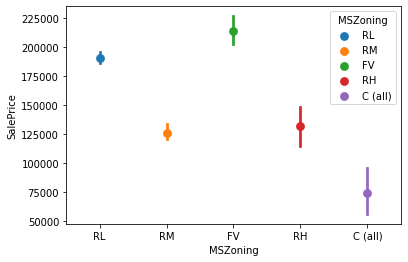

In [ ]:
sns.pointplot(data = sData, x = 'MSZoning',y = 'SalePrice', hue = 'MSZoning')

RM과 RH의 정확한 비교를 위해 두 데이터 값만 따로 비교해보도록 하자

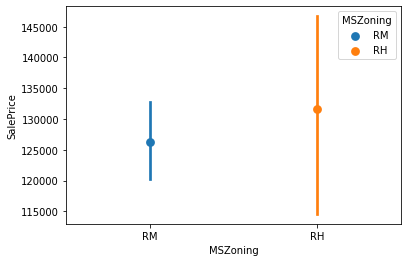

In [17]:
MSZoningD = sData[['MSZoning','SalePrice']]
condition = (MSZoningD['MSZoning'] == 'RM') | (MSZoningD['MSZoning'] == 'RH')
compRmrh = sData[condition]

sns.pointplot(data = compRmrh, x = 'MSZoning',y = 'SalePrice', hue = 'MSZoning')

유형별 가격차이가 크게 나는것을 확인할 수 있고 
pointplot으로 확인해본 결과 평균값이 높은 순으로 정렬하면 


---


### C < RM < RH < RL < FV 순으로 가격이 상승하는 것을 볼 수 있다.

## 거주지 유형에 따른 경향성

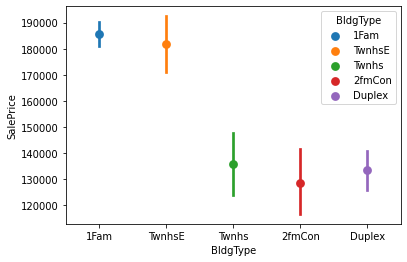

In [ ]:
BldgTypeD = sData[['BldgType','SalePrice']]

sns.pointplot(data = sData, x = 'BldgType',y = 'SalePrice', hue = 'BldgType')

## Second finished area 2에 따른 경향성

Na가 포함된 데이터이지만 Na 도 포함시켜 second finished area2 자체의 존재도 가격형성에 영향을 미치는지 알아본다

In [ ]:
BsmtFin2D = sData[['BsmtFinType2','SalePrice']]

BsmtFin2D['BsmtFinType2']=BsmtFin2D['BsmtFinType2'].fillna("None")

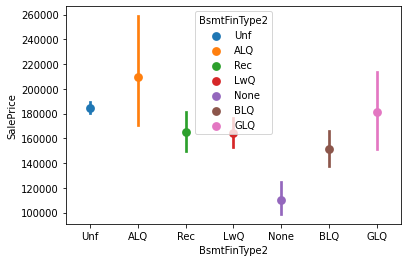

In [ ]:
sns.pointplot(data = BsmtFin2D, x = 'BsmtFinType2',y = 'SalePrice', hue = 'BsmtFinType2')

위의 그래프와 같이 second finished area2의 값이 존재하지 않는 경우 그 어떤 타입보다 낮은 가격을 형성하고 있다.



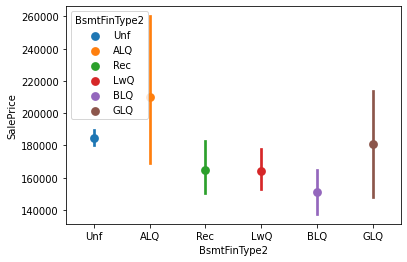

In [ ]:
sns.pointplot(data = sData, x = 'BsmtFinType2',y = 'SalePrice', hue = 'BsmtFinType2')

ALQ와 GLQ 모두 심하게 분산되어 있음으로 outlier가 있는지 다른 그래프로 확인해보도록 한다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 80.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 9.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


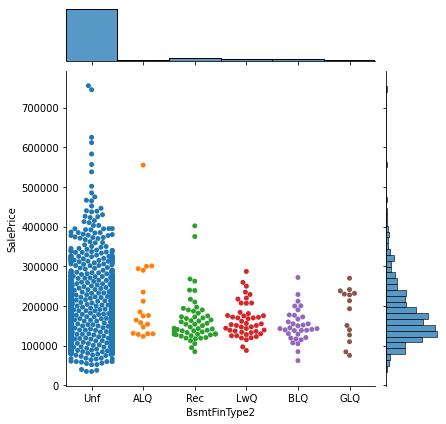

In [11]:
g = sns.JointGrid(x=sData['BsmtFinType2'], y = sData['SalePrice'])
ax = g.plot(sns.swarmplot,sns.histplot)

GLQ와 달리 AlQ는  500000이상에 Outlier가 있음으로 이 값을 제외하고 다시 그래프를 보이도록 한다.

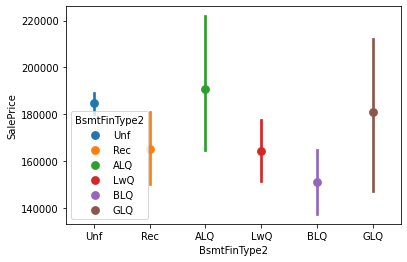

In [16]:
fixBsmt2D = sData[['BsmtFinType2', 'SalePrice']]
cond1 = (fixBsmt2D.BsmtFinType2 == 'ALQ') & (fixBsmt2D.SalePrice < 500000)  #ALQ outlier제외
cond2 = (fixBsmt2D.BsmtFinType2 != 'ALQ')
fData = fixBsmt2D.loc[cond1 | cond2]

sns.pointplot(data = fData, x = 'BsmtFinType2',y = 'SalePrice', hue = 'BsmtFinType2')

outlier 제거하고 전과 다른 형태의 값의 분포를 확인할 수 있다. 

GLQ	Good Living Quarters

ALQ	Average Living Quarters

BLQ	Below Average Living Quarters	

Rec	Average Rec Room

LwQ	Low Quality

Unf	Unfinshed



---



### BLQ < LwQ < Rec < GLQ < Unf < ALQ 순으로 가격이 상승한다.

가장 좋은 퀄리티가 높은 가격형성을 이루는 것은 아니지만 Below Average 아래보다는 Unf, GLQ, ALQ가 높은 가격형성에 기여한다.




## 다양한 도로와의 근접정도에 따른 경향성(Condition1)

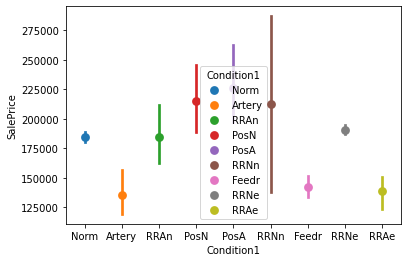

In [18]:
sns.pointplot(data = sData, x = 'Condition1',y = 'SalePrice', hue = 'Condition1')

분산정도가 큼으로 outlier가 있을 확률이 높고 IQR방식을 사용해 정리해주도록한다. 

In [28]:
def remv_outlier(data):
    Q1 = data.quantile[0.25]
    Q3 = data.quantile[0.75]
    IQR= Q3 - Q1
    return pd.DataFrame([[Q1-(1.5*IQR), Q3+(1.5*IQR)]]*data.shape[0], 
                        columns=['lower', 'upper'], 
                        index=data.index)

In [ ]:
con1D = sData[['Condition1','SalePrice']]
fixcon1D = remv_outlier(con1D)

sns.pointplot(data = fixcon1D, x = 'Condition1',y = 'SalePrice', hue = 'Condition1')

ExterCond: TA